# Introduction to Machine Learning - Final Project
## Task 2 (521K0128, 521K0143): Predict Mortality Rate base on Medical history

Dataset used: [COVID-19 Dataset by MEIR NIZRI](https://www.kaggle.com/datasets/meirnizri/covid19-dataset)

Original data from the Mexican Government [Gobierno de México - Información referente a casos COVID-19 en México](https://datos.gob.mx/busca/dataset/informacion-referente-a-casos-covid-19-en-mexico)

Dataset Information - Attributes

These fields are excluded from our analysis due to irrelevancy to the problem:
| Field                     | Description |
|---------------------------|-------------|
| **USMER**                 | Indicates whether the patient is treated in USMER or not.|
| **MEDICAL_UNIT**          | Type of institution of the National Health System that provided the care.|
| **PREGNANT**              | Whether the patient is pregnant or not. |

These fields are used for analysis and model training:

|ID | Field                     | Description |
|---|---------------------------|-------------|
|1  | **SEX**                   | 1. Female</br>2. Male|
|2  | **PATIENT_TYPE**          | Type of care the patient received in the unit: </br>1. Returned home</br>2. Hospitalized |
|3  | **DATE_DIED**             | The date of death or '9999-99-99' otherwise.|
|4  | **INTUBED**               | Whether the patient was connected to the ventilator.|
|5  | **PNEUMONIA**             | Whether the patient already have air sacs inflammation or not.|
|6  | **AGE**                   | Age of the patient.|
|7  | **DIABETES**              | Whether the patient has diabetes or not.|
|8  | **COPD**                  | Whether the patient has Chronic Obstructive Pulmonary Disease or not. |
|9  | **ASTHMA**                | Whether the patient has asthma or not. |
|10 | **INMSUPR**               | Whether the patient is immunosuppressed or not.|
|11 | **HIPERTENSION**          | Whether the patient has hypertension or not.   |
|12 | **OTHER_DISEASE**         | Whether the patient has other disease or not.  |
|13 | **CARDIOVASCULAR**        | Whether the patient has heart or blood vessels related disease. |
|14 | **OBESITY**               | Whether the patient is obese or not.    |
|15 | **RENAL_CHRONIC**         | Whether the patient has chronic renal disease or not.  |
|16 | **TOBACCO**               | Whether the patient is a tobacco user.   |
|17 | **CLASIFFICATION_FINAL**  | Covid test results. </br>Values 1-3 mean that the patient was diagnosed with COVID in different degrees. </br>4-5 means the test is inconclusive. </br>4 = `INVÁLIDO POR LABORATORIO (INVALID BY LABORATORY)`</br>5 = `NO REALIZADO POR LABORATORIO (NOT PERFORMED BY LABORATORY)`</br>6 = `CASO SOSPECHOSO (SUSPECTED CASE)` (Probably negative) </br>7 means the patient is negative with COVID. |
|18 | **ICU**                   | Whether the patient had been admitted to an Intensive Care Unit.|

### Initialization

#### Import libraries

In [138]:
import pandas as pd
import numpy as np
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import time

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.layers import Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping

from sklearn.feature_selection import SelectKBest, f_classif

#### Load data

In [2]:
df = pd.read_csv('group_task_2/Covid Data.csv')
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


#### Filtering data

Values == 98, 99 are missing values

Classification 4, 5 means the COVID test is inconclusive

In [11]:
conditions = [
    (df['INTUBED'] == 99),
    (df['PNEUMONIA'] == 99),
    (df['DIABETES'] == 98),
    (df['COPD'] == 98),
    (df['ASTHMA'] == 98),
    (df['INMSUPR'] == 98),
    (df['HIPERTENSION'] == 98),
    (df['OTHER_DISEASE'] == 98),
    (df['CARDIOVASCULAR'] == 98),
    (df['OBESITY'] == 98),
    (df['RENAL_CHRONIC'] == 98),
    (df['TOBACCO'] == 98),
    (df['CLASIFFICATION_FINAL'] == 4),
    (df['CLASIFFICATION_FINAL'] == 5),
    (df['ICU'] == 99)
]

df_filtered = df[~(reduce(lambda x, y: x | y, conditions))]
print("Number of entries removed:", df.shape[0] - df_filtered.shape[0])
print("New shape:", df_filtered.shape)

Number of entries removed: 54055
New shape: (994520, 21)


#### Data transformation

- All columns except `AGE` is converted to a boolean value
- Column names are renamed for clarity
- The list of columns for our dataset after processing is:
```
IS_MALE, IS_SENT_HOME, IS_DEAD, IS_INTUBED, HAS_PNEUMONIA, AGE, HAS_DIABETES, HAS_COPD, HAS_ASTHMA, HAS_INMSUPR, HAS_HYPERTENSION, HAS_OTHER_DISEASES, HAS_CARDIOVASCULAR, HAS_OBESITY, HAS_RENAL_CHRONIC, USE_TOBACCO, IS_POSITIVE (COVID), IS_ICU
```

In [16]:
df_cleaned = pd.DataFrame()

def true_if_2(x):
    return True if x == 2 else False

def false_if_2(x):
    return False if x == 2 else True

df_cleaned['IS_MALE'] = df_filtered['SEX'].apply(true_if_2)
df_cleaned['IS_SENT_HOME'] = df_filtered['PATIENT_TYPE'].apply(false_if_2)

df_cleaned['IS_DEAD'] = df_filtered['DATE_DIED'].apply(lambda x: False if x == '9999-99-99' else True)
df_cleaned['IS_INTUBED'] = df_filtered['INTUBED'].apply(lambda x: False if (x == 2 or x == 97) else True)

df_cleaned['HAS_PNEUMONIA'] = df_filtered['PNEUMONIA'].apply(false_if_2)

df_cleaned['AGE'] = df_filtered['AGE']

df_cleaned['HAS_DIABETES'] = df_filtered['DIABETES'].apply(false_if_2)
df_cleaned['HAS_COPD'] = df_filtered['COPD'].apply(false_if_2)
df_cleaned['HAS_ASTHMA'] = df_filtered['ASTHMA'].apply(false_if_2)
df_cleaned['HAS_INMSUPR'] = df_filtered['INMSUPR'].apply(false_if_2)
df_cleaned['HAS_HYPERTENSION'] = df_filtered['HIPERTENSION'].apply(false_if_2)
df_cleaned['HAS_OTHER_DISEASE'] = df_filtered['OTHER_DISEASE'].apply(false_if_2)
df_cleaned['HAS_CARDIOVASCULAR'] = df_filtered['CARDIOVASCULAR'].apply(false_if_2)
df_cleaned['HAS_OBESITY'] = df_filtered['OBESITY'].apply(false_if_2)
df_cleaned['HAS_RENAL_CHRONIC'] = df_filtered['RENAL_CHRONIC'].apply(false_if_2)
df_cleaned['USE_TOBACCO'] = df_filtered['TOBACCO'].apply(false_if_2)

df_cleaned['IS_POSITIVE'] = df_filtered['CLASIFFICATION_FINAL'].apply(lambda x: True if (x in [1, 2, 3]) else False)
df_cleaned['IS_ICU'] = df_filtered['ICU'].apply(lambda x: False if (x == 2 or x == 97) else True)


print("Number of entries removed:", df.shape[0] - df_cleaned.shape[0])
print("New shape:", df_cleaned.shape)
df_cleaned.head(10)

Number of entries removed: 54055
New shape: (994520, 18)


,IS_MALE,IS_SENT_HOME,IS_DEAD,IS_INTUBED,HAS_PNEUMONIA,AGE,HAS_DIABETES,HAS_COPD,HAS_ASTHMA,HAS_INMSUPR,HAS_HYPERTENSION,HAS_OTHER_DISEASE,HAS_CARDIOVASCULAR,HAS_OBESITY,HAS_RENAL_CHRONIC,USE_TOBACCO,IS_POSITIVE,IS_ICU
0,False,True,True,False,True,65,False,False,False,False,True,False,False,False,False,False,True,False
2,True,False,True,True,False,55,True,False,False,False,False,False,False,False,False,False,True,False
3,False,True,True,False,False,53,False,False,False,False,False,False,False,False,False,False,False,False
4,True,True,True,False,False,68,True,False,False,False,True,False,False,False,False,False,True,False
5,False,False,False,False,True,40,False,False,False,False,False,False,False,False,False,False,True,False
6,False,True,False,False,False,64,False,False,False,False,False,False,False,False,False,False,True,False
7,False,True,False,False,True,64,True,False,False,True,True,False,False,False,True,False,True,False
8,False,False,False,False,False,37,True,False,False,False,True,False,False,True,False,False,True,False
9,False,False,False,False,False,25,False,False,False,False,False,False,False,False,False,False,True,False
10,False,True,False,False,False,38,False,False,False,False,False,False,False,False,False,False,True,False


### Data analysis

#### Summary of the dataset

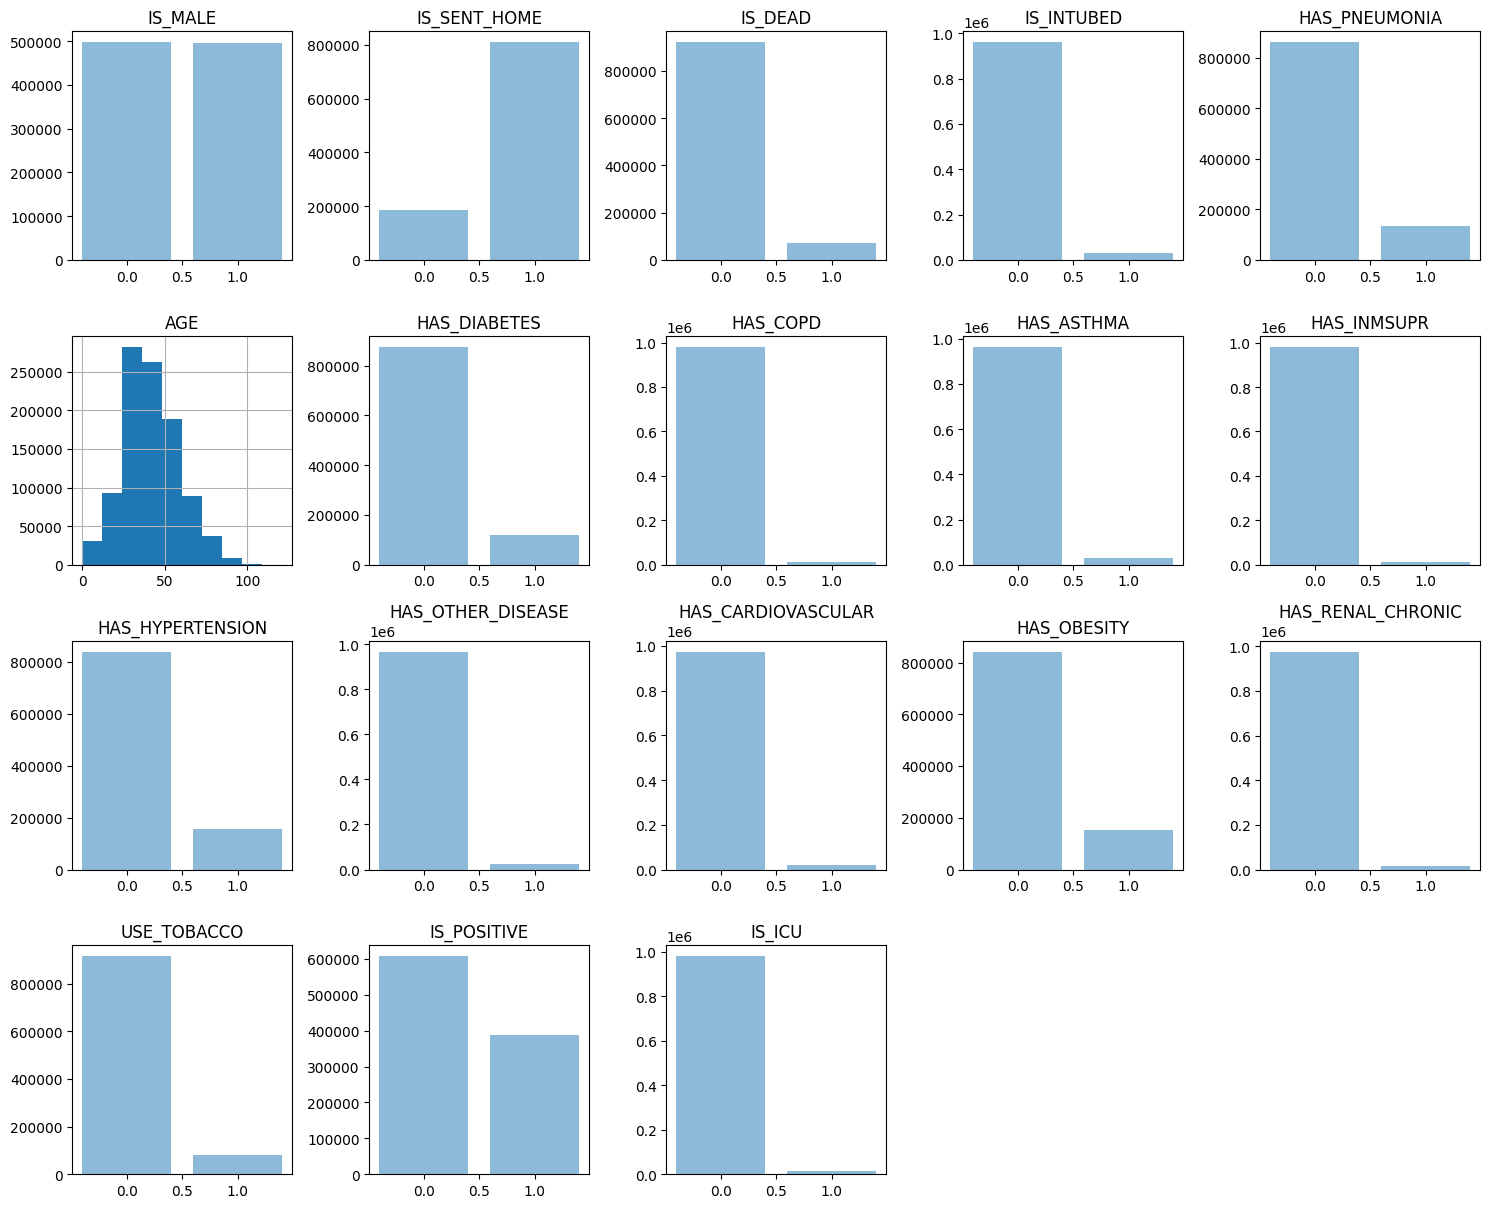

In [17]:
# Calculate the size of the grid
grid_size = int(np.ceil(np.sqrt(len(df_cleaned.columns))))

# Create a new figure with subplots
fig, axs = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(15, 15))

# Flatten the axes array
axs = axs.flatten()

# For each column in the dataframe
for i, column in enumerate(df_cleaned.columns):
    ax = axs[i]
    # If the column is 'AGE'
    if column == 'AGE':
        # Plot the distribution
        df_cleaned[column].hist(ax=ax)
        ax.set_title(column)
    else:
        # Count the number of True and False entries
        counts = df_cleaned[column].value_counts()
        # Plot the counts
        ax.bar(counts.index, counts.values, alpha=0.5)
        ax.set_title(column)

# Remove unused subplots
for i in range(len(df_cleaned.columns), len(axs)):
    fig.delaxes(axs[i])

# Adjust the layout
plt.tight_layout()
plt.show()

1. **Gender**: The dataset is gender-balanced, allowing fair health outcome comparisons.

2. **Hospitalization**: Most individuals were not hospitalized, indicating less severe cases or specific healthcare strategies.

3. **Survival**: Most individuals were alive when data was collected, hinting at a low mortality rate, pending further data.

4. **Pre-existing Conditions**: Most individuals didn't have the listed diseases, suggesting these conditions are uncommon or don't significantly impact the outcomes studied.

5. **Age**: Most individuals are under 50, reflecting the population's age distribution or a higher likelihood of younger individuals experiencing the studied outcomes.

6. **COVID-19 Status**: Despite a significant number of positive COVID-19 cases, most individuals were not affected, indicating a diverse dataset.

In conclusion, the dataset offers a broad view of the population, encompassing various ages, genders, and health conditions.

#### Correlation (Pearson)

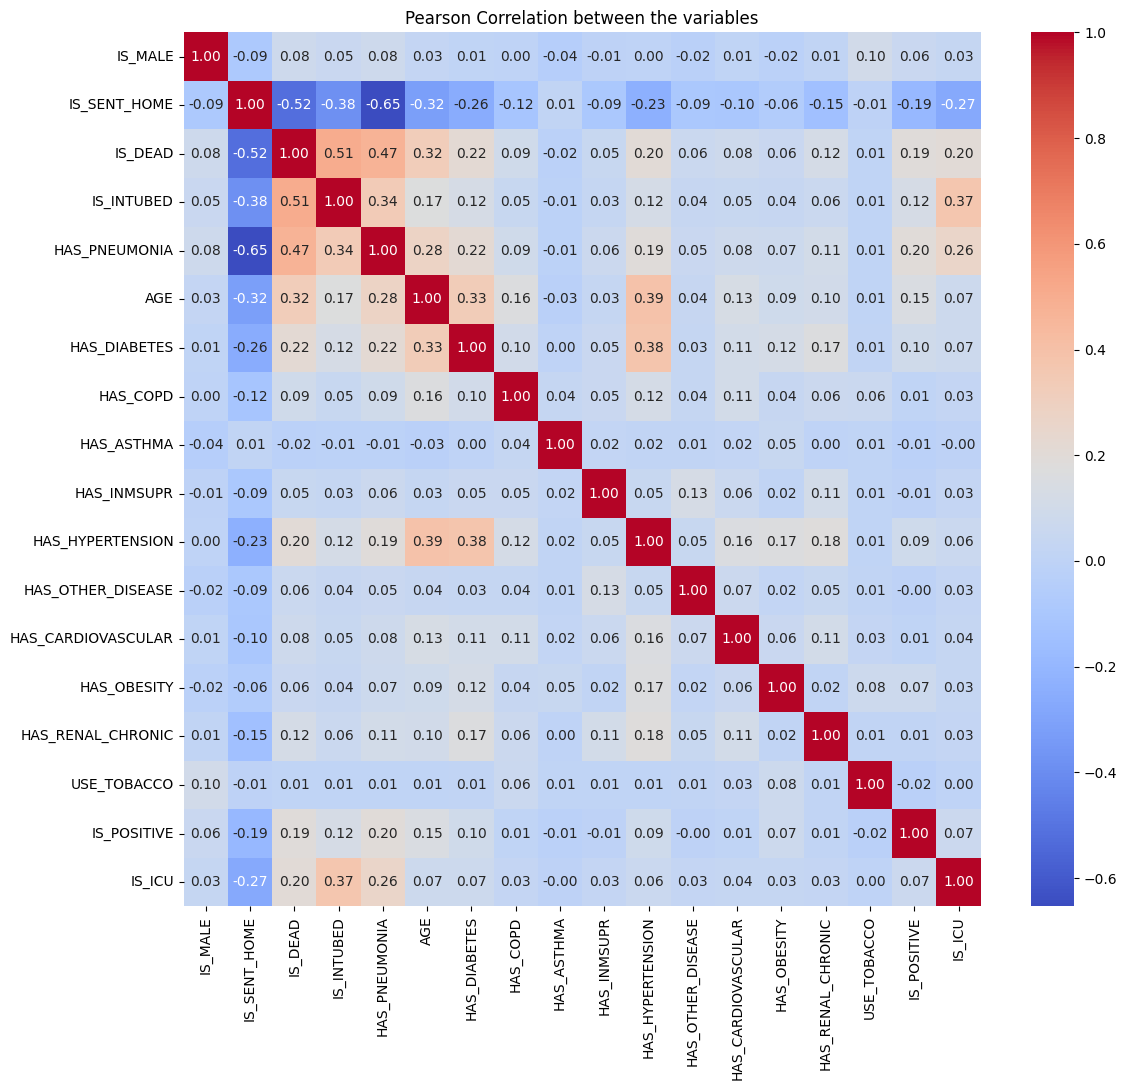

In [21]:
# Compute correlations
pearson_corr = df_cleaned.corr(method='pearson')

# Create subplots
fig, ax = plt.subplots(figsize=(12, 11))

# Plot Pearson correlation
sns.heatmap(pearson_corr, ax=ax, cmap='coolwarm', annot=True, fmt=".2f")
ax.set_title('Pearson Correlation between the variables')

plt.tight_layout()
plt.show()

1.  **Hospitalization and Mortality**:

    A negative correlation (-0.52) between being sent home and mortality suggests better health outcomes for those not hospitalized. This is supported by a strong negative correlation with pneumonia (-0.65).


2. **Age and Health/Mortality**:

    Age has a positive correlation with mortality (0.32), pneumonia (0.28), diabetes (0.33), and hypertension (0.39), indicating older individuals are more likely to have these conditions and a higher mortality rate.

3. **COVID-19 Status and Health/Mortality**:

    Low correlations of COVID-19 positivity with mortality (0.19), intubation (0.12), pneumonia (0.2), and age (0.15) suggest being COVID-19 positive doesn’t necessarily lead to higher mortality or other diseases.

4. **Hypertension and Diabetes**:

    A moderate positive correlation (0.38) between hypertension and diabetes is expected due to common risk factors.

5. **ICU Admission and Intubation**:

    A positive correlation (0.37) between ICU (Intensive Care Unit) admission and intubation is logical as ICU patients often require interventions like intubation.

6. **Mortality Factors**:

    Strong positive correlations of mortality with intubation (0.51), pneumonia (0.47), and age (0.32) suggest these are significant factors associated with mortality.

7. **Gender and Smoking**:

    Low correlation of gender and smoking with mortality (0.08 and 0.01 respectively) suggests these factors don’t significantly affect the mortality rate.

8. **Other Diseases and Immunosuppression**:

    Low correlation of other diseases and immunosuppression with mortality (0.06 and 0.05 respectively) suggests these factors don’t significantly affect the mortality rate or presence of other conditions.

From the correlation analysis, here are our conclusions:

1. **Hospitalization and Mortality**: 
    
    `IS_SENT_HOME` could be a key predictor, as non-hospitalized individuals generally had lower mortality.

2. **Age and Health Conditions**: 
    
    `AGE`, `HAS_PNEUMONIA`, `HAS_DIABETES`, and `HAS_HYPERTENSION` could be important features, as older individuals are more likely to have these conditions and higher mortality.

3. **COVID-19 Status**: 
    
    `IS_POSITIVE` might be a less significant predictor, as being COVID-19 positive doesn't necessarily lead to higher mortality or other diseases.

4. **Hypertension and Diabetes**: 

    `HAS_HYPERTENSION` and `HAS_DIABETES` could be considered in your model, but beware of potential multicollinearity.

5. **ICU Admission and Intubation**: 
    
    `IS_ICU` and `IS_INTUBED` could be significant predictors, as ICU patients often require interventions like intubation.

6. **Mortality Factors**: 
    
    `AGE`, `IS_INTUBED`, and `HAS_PNEUMONIA` are likely to be important predictors, as they're strongly associated with mortality.

7. **Gender and Smoking**: 

    `IS_MALE` and `USE_TOBACCO` might be less important features, as they don't significantly affect mortality.

8. **Other Diseases and Immunosuppression**: 

    `HAS_OTHER_DISEASE` and `HAS_INMSUPR` might be less important features, as they don't significantly affect mortality or other conditions.


#### Death rate by Disease

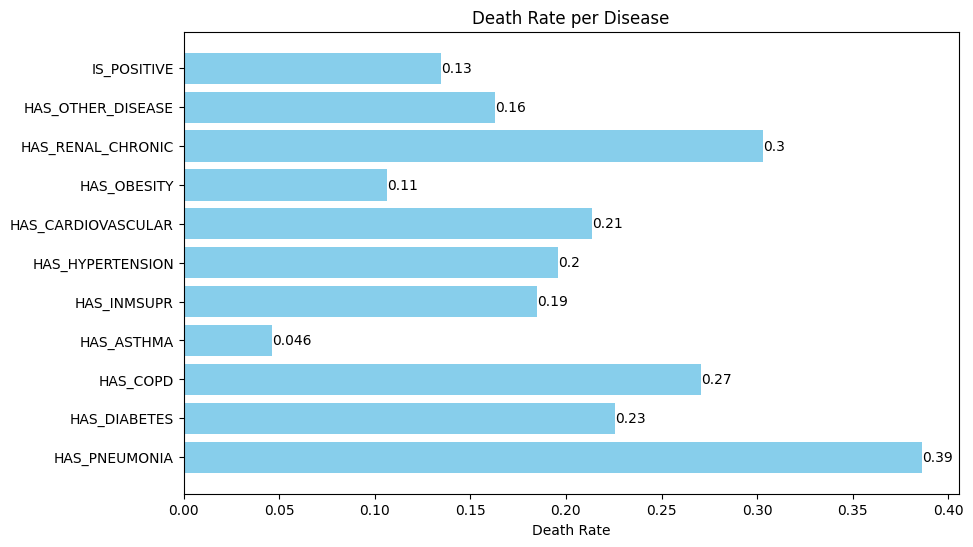

In [22]:
# List of diseases in your DataFrame
diseases = ['HAS_PNEUMONIA', 'HAS_DIABETES', 'HAS_COPD', 'HAS_ASTHMA', 'HAS_INMSUPR', 'HAS_HYPERTENSION', 'HAS_CARDIOVASCULAR', 'HAS_OBESITY', 'HAS_RENAL_CHRONIC', 'HAS_OTHER_DISEASE', 'IS_POSITIVE']

# Calculate death rate for each disease
death_rates = [df_cleaned[df_cleaned[disease] == 1]['IS_DEAD'].mean() for disease in diseases]

# Create bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(diseases, death_rates, color='skyblue')

# Add value labels to each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             '{:.2}'.format(bar.get_width()), 
             va='center', ha='left')

plt.xlabel('Death Rate')
plt.title('Death Rate per Disease')
plt.show()


From figure 3 we can make some observations: 

1. **Pneumonia**: With a death rate of 0.39, pneumonia is the most lethal condition, suggesting patients with pneumonia have a higher mortality risk.

2. **Renal Chronic & COPD**: These conditions have high death rates (0.3 and 0.27), indicating a higher mortality risk.

3. **Cardiovascular & Diabetes**: These conditions have moderate death rates (0.21 and 0.23), and could be significant mortality predictors.

4. **Hypertension & Immunosuppression**: These conditions have similar death rates (0.2 and 0.19), suggesting a moderate mortality risk.

5. **COVID-19 Status & Other Diseases**: These factors have low death rates (0.13 and 0.16), suggesting they may not significantly increase mortality risk.

6. **Obesity & Asthma**: These conditions have the lowest death rates (0.11 and 0.046), suggesting they may not be major mortality risk factors.

Comparing to the correlation analysis:

1. **Pneumonia**: Its high death rate and strong negative correlation with `IS_SENT_HOME` indicate it often requires hospitalization and is associated with higher death risk.

2. **Renal Chronic & COPD**: Their high death rates align with their moderate to strong correlations with `IS_DEAD`, indicating a higher mortality risk.

3. **Cardiovascular & Diabetes**: Their moderate death rates align with their moderate positive correlations with `AGE` and `IS_DEAD`, suggesting they could be significant mortality predictors.

4. **Hypertension & Immunosuppression**: Their similar death rates align with their moderate positive correlations with `AGE` and `IS_DEAD`.

5. **COVID-19 Status & Other Diseases**: Their low death rates align with their low correlations with `IS_DEAD`, suggesting they may not significantly increase mortality risk.

6. **Obesity & Asthma**: Their low death rates align with their low correlations with `IS_DEAD`, suggesting they may not be major mortality risk factors.

In conclusion, conditions like pneumonia, chronic renal disease, and COPD are strongly associated with mortality, while COVID-19 status, obesity, and asthma have less impact. High death rate conditions with strong correlations with `IS_DEAD` might be weighted more in the model.

#### Disease count by Gender

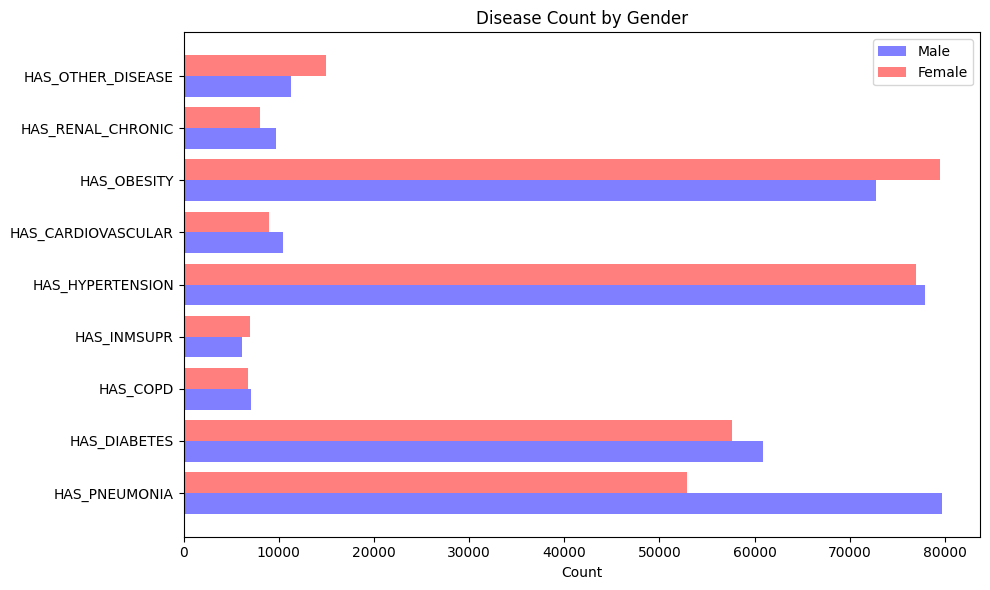

In [23]:
# List of diseases
diseases = ['HAS_PNEUMONIA', 'HAS_DIABETES', 'HAS_COPD', 'HAS_INMSUPR', 'HAS_HYPERTENSION', 'HAS_CARDIOVASCULAR', 'HAS_OBESITY', 'HAS_RENAL_CHRONIC', 'HAS_OTHER_DISEASE']

# Create a new figure
plt.figure(figsize=(10, 6))

# For each disease
for i, disease in enumerate(diseases):
    # Count the number of True entries for males and females
    male_count = df_cleaned[(df_cleaned[disease] == True) & (df_cleaned['IS_MALE'] == True)].shape[0]
    female_count = df_cleaned[(df_cleaned[disease] == True) & (df_cleaned['IS_MALE'] == False)].shape[0]
    
    # Plot the counts in the same subplot with male in blue and female in pink
    plt.barh(i-0.2, male_count, height=0.4, color='blue', alpha=0.5)
    plt.barh(i+0.2, female_count, height=0.4, color='red', alpha=0.5)

# Add labels and title
plt.title('Disease Count by Gender')
plt.xlabel('Count')
plt.yticks(range(len(diseases)), diseases)

# Add legend
plt.legend(['Male', 'Female'])

# Adjust the layout
plt.tight_layout()
plt.show()

1. **Pneumonia**: Males show a higher prevalence of pneumonia (~80,000) compared to females (~50,000), indicating a potential gender susceptibility or diagnostic differences.

2. **Diabetes, COPD, Hypertension, Cardiovascular, Renal Chronic**: The slight male dominance in these conditions is not significant, suggesting gender may not strongly influence their prevalence.

3. **Obesity, Other Diseases, Immunosuppression**: These conditions are more prevalent in females, possibly indicating a higher susceptibility or diagnostic differences.

For mortality prediction, gender may be crucial for conditions like pneumonia and obesity with noticeable gender differences. For conditions with insignificant gender differences, factors like age, hospitalization status, and comorbidity may be more relevant.

#### Age composition by gender (Deaths and COVID-Positivity)

In [31]:
def plot_age_comp_by_class(column, label_true, label_false, title):
    # Separate data by gender
    male_a = df_cleaned[(df_cleaned['IS_MALE'] == True) & (df_cleaned[column] == False)]['AGE']
    male_b = df_cleaned[(df_cleaned['IS_MALE'] == True) & (df_cleaned[column] == True)]['AGE']
    
    female_a = df_cleaned[(df_cleaned['IS_MALE'] == False) & (df_cleaned[column] == False)]['AGE']
    female_b = df_cleaned[(df_cleaned['IS_MALE'] == False) & (df_cleaned[column] == True)]['AGE']
    
    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
    
    # Plot male histogram
    axs[0].hist([male_a, male_b], bins=20, orientation='horizontal', color=['skyblue', 'red'], label=[label_false, label_true], stacked=True)
    axs[0].invert_xaxis()
    axs[0].set_title('Male')
    axs[0].legend()
    
    # Plot female histogram
    axs[1].hist([female_a, female_b], bins=20, orientation='horizontal', color=['pink', 'red'], label=[label_false, label_true], stacked=True)
    axs[1].set_title('Female')
    axs[1].legend()
    
    # Set common labels
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xlabel('Frequency')
    plt.suptitle(f'Age Composition by Gender (w. {title})')
    plt.show()

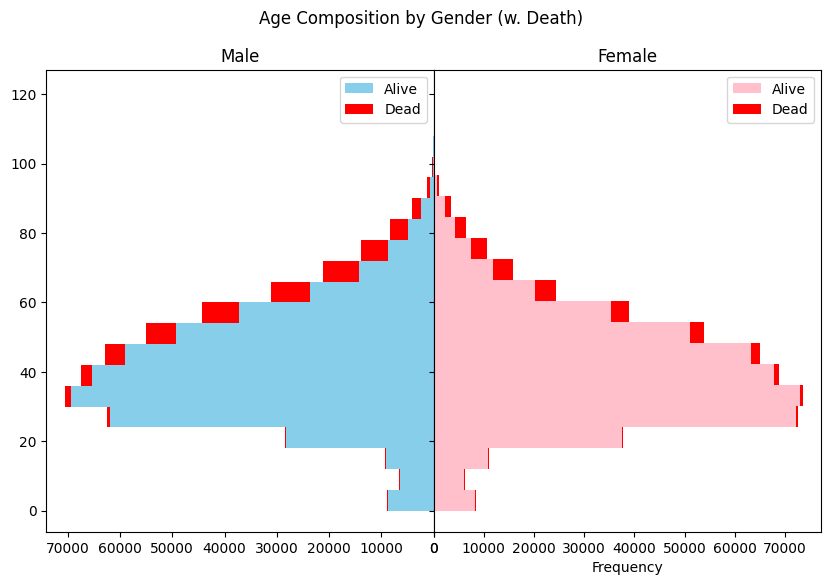

In [32]:
plot_age_comp_by_class('IS_DEAD', 'Dead', 'Alive', 'Death')

1. **Age Distribution**: Mortality peaks at 30 years, with most deaths in the 20-65 age band, suggesting middle-aged individuals face higher mortality risk.

2. **Mortality Rate**: The significantly higher number of alive individuals indicates a relatively low overall mortality rate.

3. **Youth Mortality**: The low death counts in youth (0-20) suggest lower susceptibility to fatal outcomes.

4. **Gender Differences**: The slight excess of older males who die may not be significant and could reflect dataset bias.

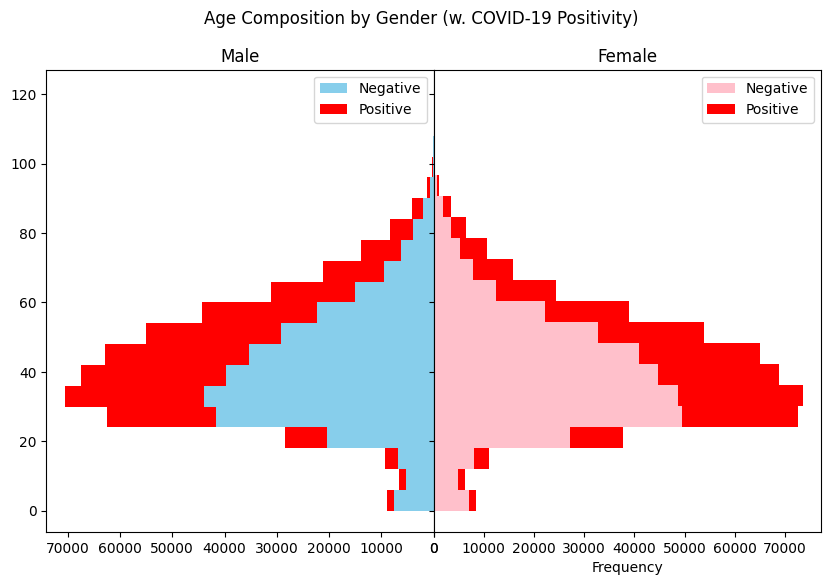

In [33]:
plot_age_comp_by_class('IS_POSITIVE', 'Positive', 'Negative', 'COVID-19 Positivity')

1. **Infection Age Distribution**: COVID-19 infections are most common in the 25-65 age group, indicating middle-aged individuals are more likely to contract the virus.

2. **Youth Infections**: The presence of infections in very young people (0-20) highlights that no age group is entirely safe.

3. **Senior Infections**: Half the population past 65 is infected, suggesting high COVID-19 risk for seniors.

For mortality prediction based on medical history, age appears to be a significant factor. The risk of infection and mortality increases with age, peaking in middle age and remaining high in seniors.

In [34]:
def plot_age_vs(column, label_true, label_false, title):
    # Create two groups in the 'AGE' column, one for dead and one for alive
    data_true = df_cleaned[df_cleaned[column] == True]['AGE']
    data_false = df_cleaned[df_cleaned[column] == False]['AGE']

    # Plot the histogram
    plt.hist([data_true, data_false], bins=20, stacked=True, color=['red', 'green'], label=[label_true, label_false])
    plt.title(f'Age vs {title}')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

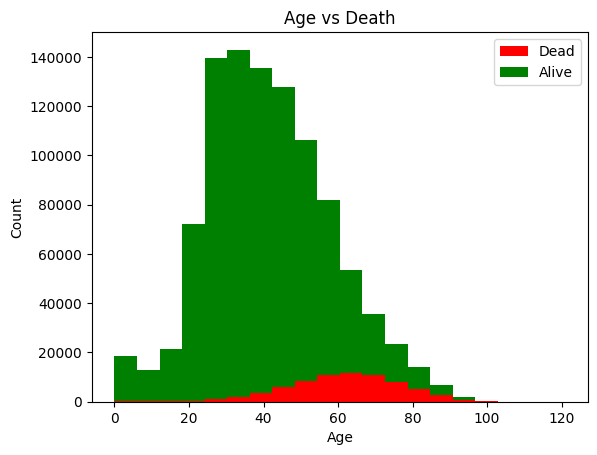

In [35]:
plot_age_vs('IS_DEAD', 'Dead', 'Alive', 'Death')

1. **Age Distribution**: The dataset is skewed towards individuals aged 20-65, possibly reflecting the population’s demographic profile or the age group most affected by the studied conditions.

2. **Death Distribution**: The higher death count in older people highlights the increased mortality risk associated with age, potentially due to factors like chronic diseases and weaker immune systems.

3. **Older Age and Mortality**: The higher death count in older people highlights the increased mortality risk associated with age, potentially due to factors like chronic diseases and weaker immune systems.

In predicting mortality based on medical history, age is a significant factor. Mortality risk increases with age, peaking around 60. These findings are specific to this dataset and may not be universally applicable.

### Basic Machine Learning (Logistic Regression, Naive Bayesian, Decision Tree, Ensemble)

#### Prepare data

In [36]:
scaler = StandardScaler()
X = df_cleaned.drop(['IS_DEAD'], axis=1)
y = df_cleaned['IS_DEAD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')
X_train.shape

(696164, 17)

#### Define models

In [37]:
class NaiveBayesModels:
    models = {
        "NB_gaussian": GaussianNB(),            # 1.1942706108093262 s
        "NB_multinomial": MultinomialNB(),    
        "NB_complement": ComplementNB(),        # 3.4857842922210693 s
        "NB_bernoulli": BernoulliNB()
    }

class DecisionTreeModels:
    models = {
        "decision_tree": DecisionTreeClassifier()   # 3.3997581005096436 s
    }

class RandomForestModels:
    models = {  # 107.4906976222992 s
        "random_forest": RandomForestClassifier(n_estimators=100, random_state=42)
    }

class GradientBoostingModels:
    models = {  # 61.89369225502014 s
        "gradient_boosting": GradientBoostingClassifier()
    }
    
class LogisticRegressionModels:
    solvers = [
        'liblinear',    # 3.0336861610412598 s
        'newton-cg',    # 8.246047258377075 s
        'lbfgs',        # 9.92334794998169 s
        'sag',          # 9.079711437225342 s
        'saga'          # 17.396028995513916 s
    ]
    
    models = {
        f"LR_{solver}": LogisticRegression(solver=solver, max_iter=10_000) for solver in solvers
    }

In [38]:
metamodels = [
    NaiveBayesModels,
    DecisionTreeModels,
    RandomForestModels,
    GradientBoostingModels,
    LogisticRegressionModels
]

#### Train basic models

In [39]:
def train_metas(metamodels, X_train, X_test):
    accuracies = {}
    confuses = {}
    class_reports = {}
    model_fit_times = {}
    for metamodel in metamodels:
        for name, model in metamodel.models.items():
            start = time.time()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            accuracy = accuracy_score(y_test, y_pred)
            confusion = confusion_matrix(y_test, y_pred)
            class_report = classification_report(y_test, y_pred)
            time_taken = time.time() - start
            print(f"Time taken: {time_taken}")
            print(f'{name} Accuracy: {accuracy}')
            print(f'{name} Confusion Matrix: \n {confusion}\n')
            print(f'{name} Classification Report: \n {class_report}')
            
            accuracies[name] = accuracy
            confuses[name] = confusion
            class_reports[name] = class_report
            model_fit_times[name] = time_taken
    return accuracies, confuses, class_reports, model_fit_times

In [40]:
accuracies, confuses, class_reports, model_fit_times = train_metas(metamodels, X_train, X_test)

Time taken: 1.215273380279541
NB_gaussian Accuracy: 0.9023582565793884
NB_gaussian Confusion Matrix: 
 [[253935  22921]
 [  6211  15289]]

NB_gaussian Classification Report: 
               precision    recall  f1-score   support

         0.0       0.98      0.92      0.95    276856
         1.0       0.40      0.71      0.51     21500

    accuracy                           0.90    298356
   macro avg       0.69      0.81      0.73    298356
weighted avg       0.93      0.90      0.91    298356

Time taken: 1.3853108882904053
NB_multinomial Accuracy: 0.9397330705600021
NB_multinomial Confusion Matrix: 
 [[269510   7346]
 [ 10635  10865]]

NB_multinomial Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.97      0.97    276856
         1.0       0.60      0.51      0.55     21500

    accuracy                           0.94    298356
   macro avg       0.78      0.74      0.76    298356
weighted avg       0.94      0.94      

C:\Users\wr0n9\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\wr0n9\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Time taken: 8.215850830078125
LR_newton-cg Accuracy: 0.9490608534770543
LR_newton-cg Confusion Matrix: 
 [[272441   4415]
 [ 10783  10717]]

LR_newton-cg Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97    276856
         1.0       0.71      0.50      0.59     21500

    accuracy                           0.95    298356
   macro avg       0.84      0.74      0.78    298356
weighted avg       0.94      0.95      0.94    298356

Time taken: 10.623300313949585
LR_lbfgs Accuracy: 0.949034039871831
LR_lbfgs Confusion Matrix: 
 [[272449   4407]
 [ 10799  10701]]

LR_lbfgs Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97    276856
         1.0       0.71      0.50      0.58     21500

    accuracy                           0.95    298356
   macro avg       0.84      0.74      0.78    298356
weighted avg       0.94      0.95      0.94    298356



#### Basic models analysis

##### Training time

In [41]:
def plot_time(model_fit_times, max_x=120):
    plt.figure(figsize=(10, 5))
    bars = plt.barh(list(model_fit_times.keys()), list(model_fit_times.values()))
    plt.ylabel('Model')
    plt.xlabel('Training Time (s)')
    plt.title("Basic models' training time")

    # Add value labels at the end of each bar
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
                f'{bar.get_width():.4f}', 
                va='center', ha='left')

    plt.xlim(0, max_x)

    plt.tight_layout()
    plt.show()


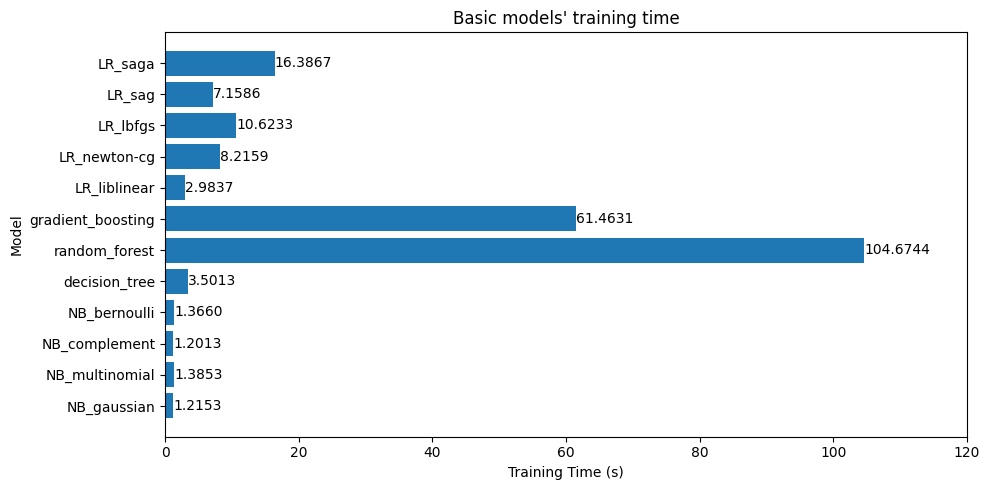

In [42]:
plot_time(model_fit_times)

Random Forest and Gradient Boosting models took the longest to train due to their complexity. In contrast, Naive Bayes and Decision Tree models were quicker.


##### Model accuracy

In [43]:
def plot_accuracies(accuracies):
    plt.figure(figsize=(7, 5))
    bars = plt.barh(list(accuracies.keys()), list(accuracies.values()))
    plt.ylabel('Model')
    plt.xlabel('Accuracy')
    plt.title("Basic models' accuracy")

    # Add value labels at the end of each bar
    for bar in bars:
        plt.text(bar.get_width() + 0.01,  # Add a small offset to the x-position
                bar.get_y() + bar.get_height()/2, 
                f'{bar.get_width():.4f}', 
                va='center', ha='left')

    plt.tight_layout()

    # Increase the x-axis limit
    plt.xlim(0, max(accuracies.values()) * 1.2)

    plt.show()

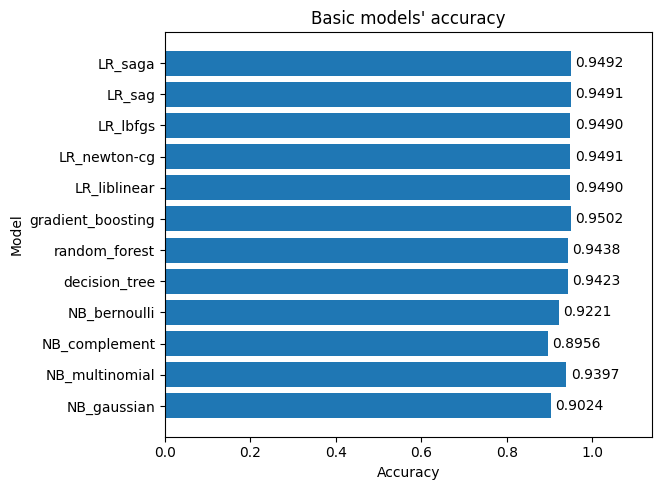

In [44]:
plot_accuracies(accuracies)

Gradient Boosting model showed the highest accuracy, followed by Logistic Regression and Random Forest models. Gaussian and Complement Naive Bayes models had the lowest accuracy scores. However, the accuracy variation between models is small, indicating good performance on this dataset.

##### Confusion matrix

In [72]:
for name, report in class_reports.items():
    print(name)
    print(report)

NB_gaussian
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95    276856
         1.0       0.40      0.71      0.51     21500

    accuracy                           0.90    298356
   macro avg       0.69      0.81      0.73    298356
weighted avg       0.93      0.90      0.91    298356

NB_multinomial
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97    276856
         1.0       0.60      0.51      0.55     21500

    accuracy                           0.94    298356
   macro avg       0.78      0.74      0.76    298356
weighted avg       0.94      0.94      0.94    298356

NB_complement
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.94    276856
         1.0       0.40      0.86      0.54     21500

    accuracy                           0.90    298356
   macro avg       0.69      0.88      0.74    298356
weighted avg       0.95      0.90

In [68]:
def plot_confuses(confuses, num_vert=3, num_hor=4, figsize=(20, 10)):
    fig, axs = plt.subplots(num_vert, num_hor, figsize=figsize)

    for ax, (method, cm) in zip(axs.flatten(), confuses.items()):
        im = ax.matshow(cm, cmap='Blues')
        ax.set_title(method)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        
        # Choose text color based on cell value
        threshold = im.norm(cm.max())/2.
        textcolors = ["black", "white"]
        
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, f'{cm[i, j]}', ha='center', va='center',
                        color=textcolors[int(im.norm(cm[i, j]) > threshold)])

    plt.tight_layout()
    plt.show()


- **True Positives (TP)**: These are cases in which the model predicted the individual would die (`IS_DEAD`=1), and they did die.
- **True Negatives (TN)**: These are cases in which the model predicted the individual would not die (`IS_DEAD`=0), and they did not die.
- **False Positives (FP)**: These are cases in which the model predicted the individual would die, but they did not die.
- **False Negatives (FN)**: These are cases in which the model predicted the individual would not die, but they did die.

For each model, the confusion matrix is structured as follows:
```
[[TN, FP]
 [FN, TP]]
```

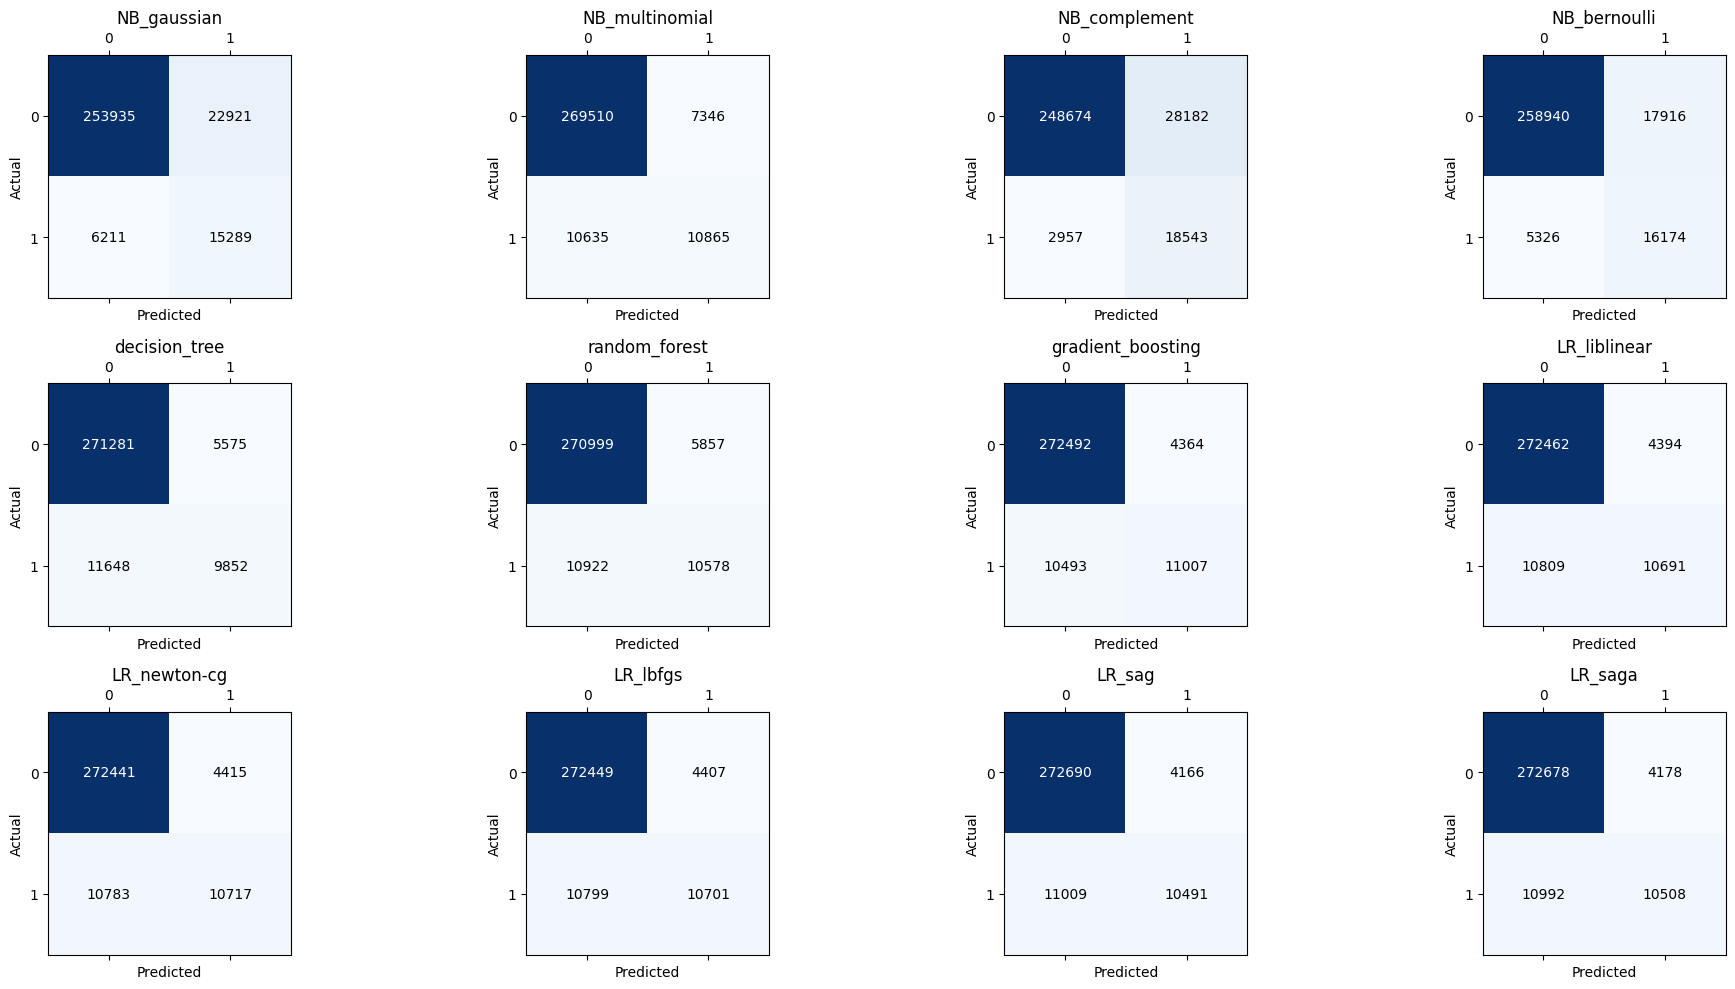

In [66]:
plot_confuses(confuses)

| Model | Highs | Lows | Pros | Cons |
| --- | --- | --- | --- | --- |
| Gaussian Naive Bayes | TN = 253,935, TP = 15,289 | FP = 22,921 | Good at predicting survival and death | May overestimate death risk, high false death prediction for survivors |
| Multinomial Naive Bayes | TN = 269,510, TP = 10,865 | FP = 7,346 | Excellent at predicting survival, low false death prediction for survivors | May underestimate death risk, lower true death prediction |
| Complement Naive Bayes | TN = 248,674, TP = 18,543 | FP = 28,182 | Good at predicting survival and death, high true death prediction | May overestimate death risk, highest false death prediction for survivors |
| Bernoulli Naive Bayes | TN = 258,940, TP = 16,174 | FP = 17,916 | Balanced prediction of survival and death | Moderate false death prediction for survivors |
| Decision Tree | TN = 271,281, TP = 9,850 | FP = 5,575 | Good at predicting survival, low false death prediction for survivors | May underestimate death risk, lowest true death prediction |
| Random Forest | TN = 270,999, TP = 10,578 | FP = 5,857 | Good overall performance, low false death prediction for survivors | Moderate true death prediction |
| Gradient Boosting | TN = 272,492, TP = 11,007 | FP = 4,364 | Excellent overall performance, lowest false death prediction for survivors | Moderate true death prediction |
| Logistic Regression Models | TN > 272,400, TP > 10,500 | - | Good overall performance, low false death prediction for survivors | Moderate true death prediction |

The "**Highs**" column refers to high counts of True Negatives (TN) and True Positives (TP), indicating good performance in correctly predicting survival and death. The "**Lows**" column refers to high counts of False Positives (FP), suggesting the model may overestimate the risk of death. The "**Pros**" and "**Cons**" columns summarize the strengths and weaknesses of each model.

For predicting mortality, consider these models:

1. **Complement Naive Bayes**: High True Positive rate, good at predicting death, but may overestimate death risk due to high False Positive rate.

2. **Bernoulli Naive Bayes**: Balanced prediction of survival and death, moderate rate of false death prediction, suitable if sensitivity and specificity are equally important.

3. **Gradient Boosting**: Excellent overall performance, lowest false death prediction, moderate true death prediction.

4. **Logistic Regression Models**: Good overall performance, low false death prediction, moderate true death prediction.

Prioritize models like Complement Naive Bayes for accurate death prediction. For avoiding overestimation of death risk, consider models like Gradient Boosting.


### FFNN and RNN

#### FFNN

In [48]:
model_ffnn = Sequential()
model_ffnn.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model_ffnn.add(Dense(32, activation='relu'))
model_ffnn.add(Dense(16, activation='relu'))
model_ffnn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_ffnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model_ffnn.fit(X_train, y_train, epochs=50, batch_size=1000)




Epoch 1/50


697/697 [==============================] - 3s 3ms/step - loss: 0.1690 - accuracy: 0.9356
Epoch 2/50
697/697 [==============================] - 2s 2ms/step - loss: 0.1178 - accuracy: 0.9482
Epoch 3/50
697/697 [==============================] - 2s 2ms/step - loss: 0.1172 - accuracy: 0.9485
Epoch 4/50
697/697 [==============================] - 2s 3ms/step - loss: 0.1172 - accuracy: 0.9484
Epoch 5/50
697/697 [==============================] - 2s 3ms/step - loss: 0.1166 - accuracy: 0.9490
Epoch 6/50
697/697 [==============================] - 2s 2ms/step - loss: 0.1166 - accuracy: 0.9489
Epoch 7/50
697/697 [==============================] - 2s 3ms/step - loss: 0.1166 - accuracy: 0.9490
Epoch 8/50
697/697 [==============================] - 2s 3ms/step - loss: 0.1163 - accuracy: 0.9492
Epoch 9/50
697/697 [==============================] - 2s 3ms/step - loss: 0.1165 - accuracy: 0.9492
Epoch 10/50
697/697 [==============================] - 2s 3ms/step - loss: 0.1163 - accuracy: 0.

In [56]:
def plot_history(history, title):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'])
    plt.title(f'{title} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'])
    plt.title(f'{title} model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper left')
    plt.show()


#### RNN

In [58]:
X_train_rnn = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Define the model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(64, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='relu'))
model_rnn.add(Dense(32, activation='relu'))
model_rnn.add(Dense(16, activation='relu'))
model_rnn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_rnn = model_rnn.fit(X_train_rnn, y_train, epochs=50, batch_size=1000)


Epoch 1/50
697/697 [==============================] - 4s 4ms/step - loss: 0.1653 - accuracy: 0.9380
Epoch 2/50
697/697 [==============================] - 3s 4ms/step - loss: 0.1180 - accuracy: 0.9481
Epoch 3/50
697/697 [==============================] - 3s 4ms/step - loss: 0.1175 - accuracy: 0.9481
Epoch 4/50
697/697 [==============================] - 2s 3ms/step - loss: 0.1173 - accuracy: 0.9485
Epoch 5/50
697/697 [==============================] - 2s 3ms/step - loss: 0.1171 - accuracy: 0.9486
Epoch 6/50
697/697 [==============================] - 2s 3ms/step - loss: 0.1166 - accuracy: 0.9488
Epoch 7/50
697/697 [==============================] - 2s 3ms/step - loss: 0.1165 - accuracy: 0.9488
Epoch 8/50
697/697 [==============================] - 2s 3ms/step - loss: 0.1164 - accuracy: 0.9489
Epoch 9/50
697/697 [==============================] - 2s 3ms/step - loss: 0.1163 - accuracy: 0.9491
Epoch 10/50
697/697 [==============================] - 2s 3ms/step - loss: 0.1165 - accuracy: 0.9490

#### FFNN and RNN evaluation

In [74]:
def plot_history_two(hist_a, hist_b, name_a, name_b):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.plot(hist_a.history['accuracy'])
    plt.plot(hist_b.history['accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend([name_a, name_b], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.plot(hist_a.history['loss'])
    plt.plot(hist_b.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend([name_a, name_b], loc='upper left')
    plt.show()


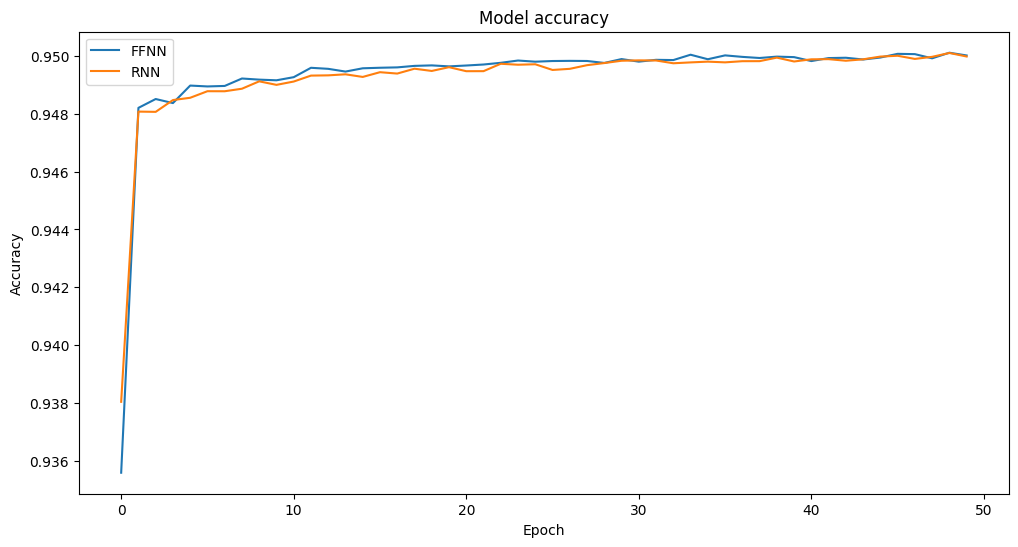

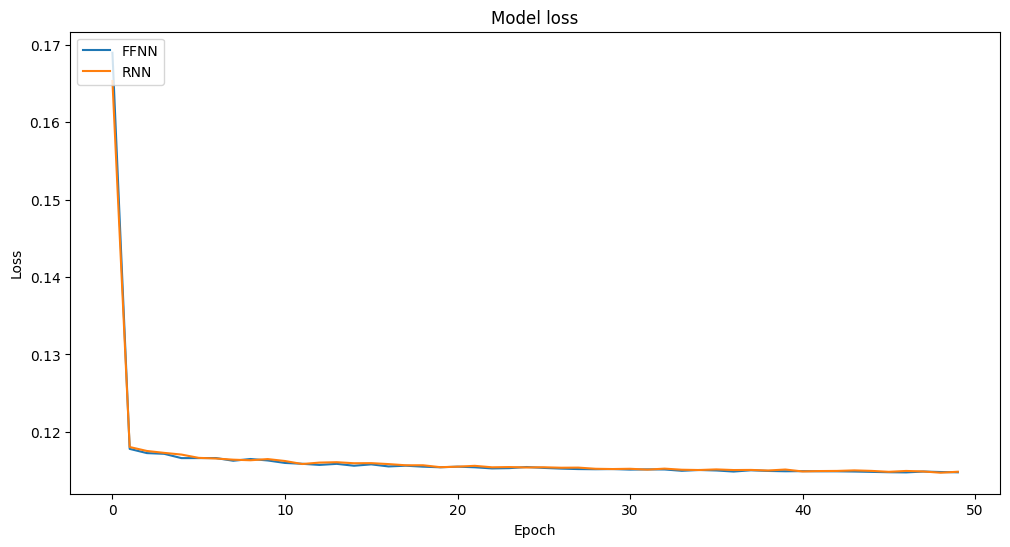

In [75]:
plot_history_two(history, history_rnn, "FFNN", "RNN")

The FFNN and RNN models achieved comparable results with basic models. Accuracy increased from 0.93 to 0.95, and loss decreased from 0.16 to 0.11 over 50 epochs. Minor fluctuations in metrics are due to the stochastic nature of the Adam optimizer. Plateauing of accuracy and loss suggests models might have reached their learning capacity with the current data and architectures.

In [62]:
# Get model predictions

print("Predicting FFNN")
y_pred_ffnn_prob = model_ffnn.predict(X_test)

print("Predicting RNN")
y_pred_rnn_prob = model_rnn.predict(X_test_rnn)

# Convert probabilities to class labels
y_pred_ffnn = (y_pred_ffnn_prob > 0.5).astype(int)
y_pred_rnn = (y_pred_rnn_prob > 0.5).astype(int)

Predicting FFNN
9324/9324 [==============================] - 13s 1ms/step
Predicting RNN
9324/9324 [==============================] - 16s 2ms/step


In [63]:
class_report_ffnn = classification_report(y_test, y_pred_ffnn)
confuse_ffnn = confusion_matrix(y_test, y_pred_ffnn)

class_report_rnn = classification_report(y_test, y_pred_rnn)
confuse_rnn = confusion_matrix(y_test, y_pred_rnn)

confuses_nn = {
    "FFNN": confuse_ffnn,
    "RNN": confuse_rnn
}

# For the FFNN model
print("FFNN Model:")
print(class_report_ffnn)
print(confuse_ffnn)

# For the RNN model
print("\nRNN Model:")
print(class_report_rnn)
print(confuse_rnn)

FFNN Model:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97    276856
         1.0       0.74      0.47      0.57     21500

    accuracy                           0.95    298356
   macro avg       0.85      0.73      0.77    298356
weighted avg       0.94      0.95      0.94    298356

[[273391   3465]
 [ 11436  10064]]

RNN Model:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97    276856
         1.0       0.73      0.50      0.59     21500

    accuracy                           0.95    298356
   macro avg       0.84      0.74      0.78    298356
weighted avg       0.94      0.95      0.95    298356

[[272845   4011]
 [ 10832  10668]]


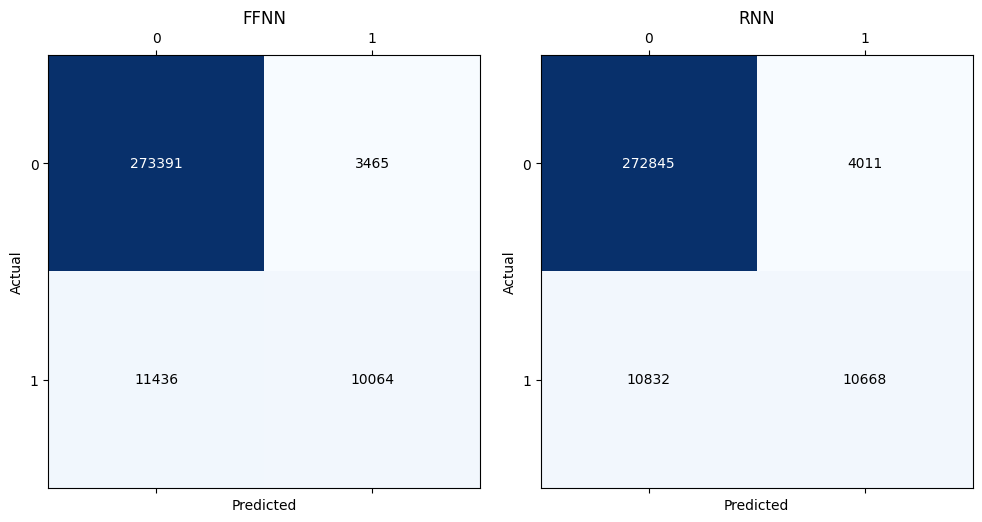

In [69]:
plot_confuses(confuses_nn, 1, 2, (10, 5))

| Model | Highs | Lows | Pros | Cons |
| --- | --- | --- | --- | --- |
| FFNN | TN = 273,391, TP = 10,064 | FP = 3,465 | Good overall performance, low false death prediction | Moderate true death prediction |
| RNN | TN = 272,845, TP = 10,668 | FP = 4,011 | Good overall performance, low false death prediction | Moderate true death prediction |

- **Feedforward Neural Network (FFNN)**: Performs well overall with a low rate of false death predictions. However, its true death prediction rate is moderate. It has a high True Negative (TN) count of 273,391 and a True Positive (TP) count of 10,064, but a relatively low False Positive (FP) count of 3,465.

- **Recurrent Neural Network (RNN)**: Similar to FFNN, it performs well overall with a low rate of false death predictions. It has a slightly higher true death prediction rate than FFNN. The RNN has a TN count of 272,845, a TP count of 10,668, and a FP count of 4,011.

- **Basic Models (e.g., Gaussian Naive Bayes, Multinomial Naive Bayes, etc.)**: These models show varied performance. Some may overestimate the risk of death, while others may underestimate it. The rate of correctly predicting death also varies among these models.

In conclusion, both FFNN and RNN models perform well on this dataset, striking a good balance between predicting survival and death.

### Overfitting Prevention

#### Basic models

##### Cross validation

In [69]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# Cross-Validation
for metamodel in metamodels:
    for name, model in metamodel.models.items():
        scores = cross_val_score(model, X_train, y_train, cv=5)
        print(f'{name} Cross-Validation Scores: {scores}')

NB_gaussian Cross-Validation Scores: [0.90183362 0.90276012 0.9025662  0.90304741 0.90258705]
NB_multinomial Cross-Validation Scores: [0.93939655 0.93951865 0.9401435  0.93905899 0.93963313]
NB_complement Cross-Validation Scores: [0.89535527 0.89625304 0.89654033 0.89552764 0.89574954]
NB_bernoulli Cross-Validation Scores: [0.92118248 0.92198689 0.92320068 0.92103883 0.92192168]
decision_tree Cross-Validation Scores: [0.94155121 0.94156558 0.94204678 0.94180977 0.94120604]
random_forest Cross-Validation Scores: [0.94332522 0.94405062 0.94384952 0.94377051 0.94263531]
gradient_boosting Cross-Validation Scores: [0.9502345  0.94960965 0.9498323  0.95019859 0.94947282]
LR_liblinear Cross-Validation Scores: [0.94850359 0.94827376 0.94865441 0.94843895 0.94831648]


C:\Users\wr0n9\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\wr0n9\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\wr0n9\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_linesearch.py:425: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
C:\Users\wr0n9\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\wr0n9\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
C:\Users\

LR_newton-cg Cross-Validation Scores: [0.94856105 0.94826657 0.94864005 0.94847486 0.94825902]
LR_lbfgs Cross-Validation Scores: [0.94852513 0.94824503 0.9486185  0.94846768 0.94831648]
LR_sag Cross-Validation Scores: [0.94864005 0.94823066 0.94844613 0.94863287 0.94839548]
LR_saga Cross-Validation Scores: [0.94887706 0.94830967 0.94855386 0.94861132 0.94835239]


| Model | Min Score | Max Score | Mean Score | Analysis |
| --- | --- | --- | --- | --- |
| Gaussian Naive Bayes | 0.9018 | 0.9030 | 0.9026 | Consistent and good performance |
| Multinomial Naive Bayes | 0.9391 | 0.9401 | 0.9396 | Very good and consistent performance |
| Complement Naive Bayes | 0.8954 | 0.8965 | 0.8960 | Good and consistent performance |
| Bernoulli Naive Bayes | 0.9210 | 0.9232 | 0.9217 | Very good and consistent performance |
| Decision Tree | 0.9412 | 0.9420 | 0.9416 | Very good and consistent performance |
| Random Forest | 0.9426 | 0.9441 | 0.9437 | Very good and consistent performance |
| Gradient Boosting | 0.9495 | 0.9502 | 0.9499 | Excellent and consistent performance |
| Logistic Regression Models | 0.9482 | 0.9489 | 0.9486 | Excellent and consistent performance |

The "Min Score" and "Max Score" columns show the range of cross-validation scores for each model, while the "Mean Score" column shows the average score. The "Analysis" column provides a brief interpretation of these scores. 

##### Feature selection

In [71]:
X_train

,IS_MALE,IS_SENT_HOME,IS_INTUBED,HAS_PNEUMONIA,AGE,HAS_DIABETES,HAS_COPD,HAS_ASTHMA,HAS_INMSUPR,HAS_HYPERTENSION,HAS_OTHER_DISEASE,HAS_CARDIOVASCULAR,HAS_OBESITY,HAS_RENAL_CHRONIC,USE_TOBACCO,IS_POSITIVE,IS_ICU
406924,1.0,1.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
267666,0.0,1.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
689877,1.0,0.0,0.0,1.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
682667,0.0,1.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
775711,1.0,1.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273745,1.0,1.0,0.0,0.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
384791,1.0,1.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
134833,1.0,1.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
720312,0.0,1.0,0.0,0.0,54.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [78]:
selector = SelectKBest(score_func=f_classif, k=10)  # Select top 10 features
X_new = selector.fit_transform(X_train, y_train)

# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
X_train_new = X_train.iloc[:,cols]
X_test_new = X_test.iloc[:,cols]

The features selected are
```
['IS_SENT_HOME', 'IS_INTUBED', 'HAS_PNEUMONIA', 'AGE', 'HAS_DIABETES', 
'HAS_COPD', 'HAS_HYPERTENSION', 'HAS_RENAL_CHRONIC', 'IS_POSITIVE','IS_ICU']
```

The features discarded are
```
['IS_MALE', 'HAS_ASTHMA', 'HAS_INMSUPR', 'HAS_OTHER_DISEASE', 
'HAS_CARDIOVASCULAR', 'HAS_OBESITY', 'USE_TOBACCO',]
```

This is consistent with our findings in the correlation between variables.

In [79]:
X_train_new

,IS_SENT_HOME,IS_INTUBED,HAS_PNEUMONIA,AGE,HAS_DIABETES,HAS_COPD,HAS_HYPERTENSION,HAS_RENAL_CHRONIC,IS_POSITIVE,IS_ICU
406924,1.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,1.0,0.0
267666,1.0,0.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0
689877,0.0,0.0,1.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0
682667,1.0,0.0,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0
775711,1.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
273745,1.0,0.0,0.0,56.0,0.0,0.0,0.0,0.0,0.0,0.0
384791,1.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,1.0,0.0
134833,1.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,1.0,0.0
720312,1.0,0.0,0.0,54.0,1.0,0.0,1.0,0.0,0.0,0.0


In [81]:
feat_accuracies, feat_confuses, feat_class_reports, feat_model_fit_times = train_metas(metamodels, X_train_new, X_test_new)

Time taken: 1.0731825828552246
NB_gaussian Accuracy: 0.9177827829840861
NB_gaussian Confusion Matrix: 
 [[257822  19034]
 [  5496  16004]]

NB_gaussian Classification Report: 
               precision    recall  f1-score   support

         0.0       0.98      0.93      0.95    276856
         1.0       0.46      0.74      0.57     21500

    accuracy                           0.92    298356
   macro avg       0.72      0.84      0.76    298356
weighted avg       0.94      0.92      0.93    298356

Time taken: 1.1232540607452393
NB_multinomial Accuracy: 0.940420169193849
NB_multinomial Confusion Matrix: 
 [[269957   6899]
 [ 10877  10623]]

NB_multinomial Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97    276856
         1.0       0.61      0.49      0.54     21500

    accuracy                           0.94    298356
   macro avg       0.78      0.73      0.76    298356
weighted avg       0.94      0.94      

C:\Users\wr0n9\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\wr0n9\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\optimize.py:204: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


Time taken: 6.701078653335571
LR_newton-cg Accuracy: 0.9488329378326563
LR_newton-cg Confusion Matrix: 
 [[272465   4391]
 [ 10875  10625]]

LR_newton-cg Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97    276856
         1.0       0.71      0.49      0.58     21500

    accuracy                           0.95    298356
   macro avg       0.83      0.74      0.78    298356
weighted avg       0.94      0.95      0.94    298356

Time taken: 5.788855791091919
LR_lbfgs Accuracy: 0.9488161793293918
LR_lbfgs Confusion Matrix: 
 [[272466   4390]
 [ 10881  10619]]

LR_lbfgs Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97    276856
         1.0       0.71      0.49      0.58     21500

    accuracy                           0.95    298356
   macro avg       0.83      0.74      0.78    298356
weighted avg       0.94      0.95      0.94    298356



In [125]:
def plot_time_versus(time_a, time_b, max_x=130):
    labels = list(time_a.keys())
    time_a_vals = list(time_a.values())
    time_b_vals = list(time_b.values())

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(7, 7))

    rects1 = ax.barh(x + width/2, time_b_vals, width, label='Before feat. select')
    rects2 = ax.barh(x - width/2, time_a_vals, width, label='After feat. select')

    ax.set_xlabel('Training Time (s)')
    ax.set_title("Models' training time comparison")
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3, fmt='%.4f')
    ax.bar_label(rects2, padding=3, fmt='%.4f')

    fig.tight_layout()
    plt.xlim(0, max_x)
    plt.show()


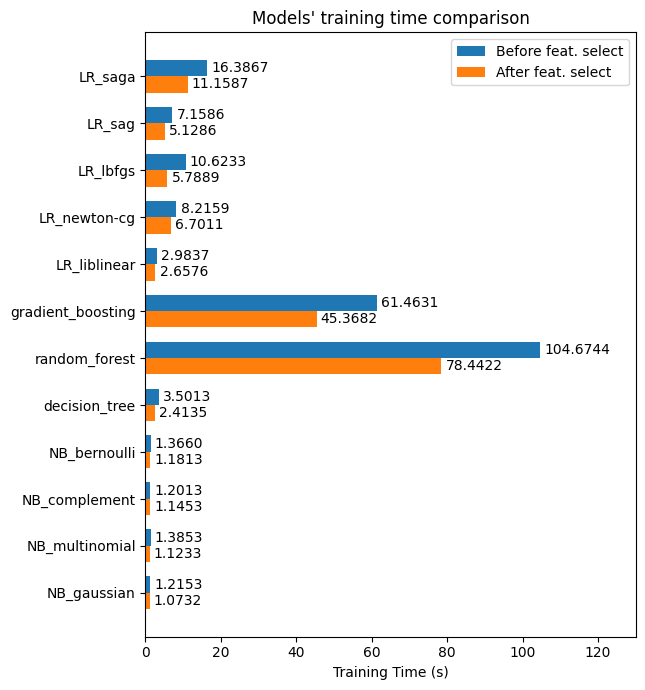

In [126]:
plot_time_versus(feat_model_fit_times, model_fit_times)

The results indicate that reducing the number of features from 17 to 10 significantly decreased the training time for all models. This is due to the reduced computational complexity associated with fewer features. 

In [136]:
def plot_accuracies_versus(accuracies_a, accuracies_b, max_x=1.2):
    labels = list(accuracies_a.keys())
    accuracies_a_vals = list(accuracies_a.values())
    accuracies_b_vals = list(accuracies_b.values())

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(7, 7))

    rects1 = ax.barh(x + width/2, accuracies_a_vals, width, label='Before feat. select')
    rects2 = ax.barh(x - width/2, accuracies_b_vals, width, label='After feat. select')

    ax.set_xlabel('Accuracy')
    ax.set_title("Models' accuracy comparison")
    ax.set_yticks(x)
    ax.set_yticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3, fmt='%.4f')
    ax.bar_label(rects2, padding=3, fmt='%.4f')

    fig.tight_layout()
    plt.xlim(0, max(max(accuracies_a.values()), max(accuracies_b.values())) * max_x)
    plt.legend(loc='lower left')
    plt.show()


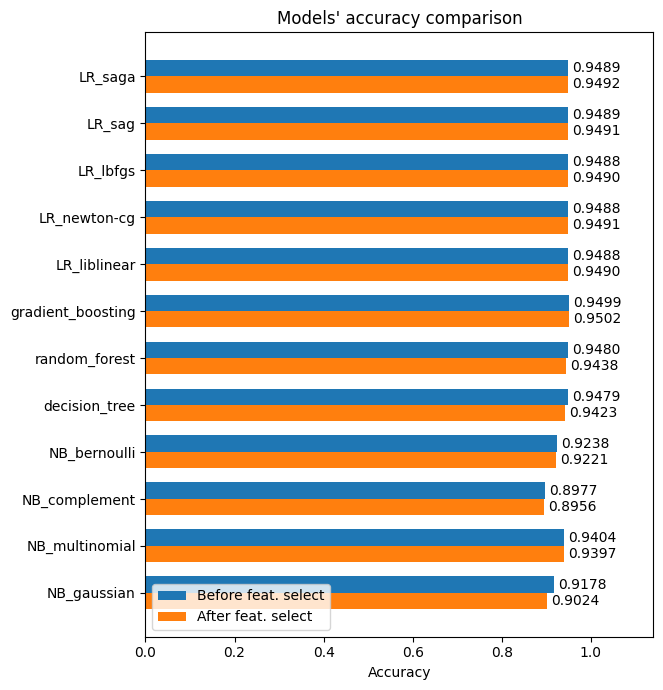

In [137]:
plot_accuracies_versus(feat_accuracies, accuracies)

However, the accuracy of the models did not improve significantly. In some cases, there was even a slight decrease in accuracy. This suggests that the discarded features may not have significantly contributed to the model’s predictive accuracy.

In conclusion, feature selection has enhanced the efficiency of the models in terms of computational resources and time, without significantly affecting their performance. This represents a common trade-off between efficiency and performance in machine learning and data science.

#### FFNN, RNN

To prevent overfitting in Feedforward Neural Networks (FFNN) and Recurrent Neural Networks (RNN), several strategies were employed:

1. **Regularization**: The `kernel_regularizer` parameter was added to the `Dense` layers. This L2 regularization penalizes large weights by adding a penalty to the loss function, helping to prevent overfitting.

2. **Dropout**: `Dropout` layers were introduced after each `Dense` layer. These layers randomly nullify approximately half of the input units during each training update, which aids in overfitting prevention.

3. **Early Stopping**: This form of regularization halts the training process when the model's performance on a validation dataset ceases to improve after a certain number of epochs. In this case, if 'val_loss' doesn't improve after 10 epochs, training is stopped.

In [139]:
model_ffnn_new = Sequential()
model_ffnn_new.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_ffnn_new.add(Dropout(0.5))
model_ffnn_new.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_ffnn_new.add(Dropout(0.5))
model_ffnn_new.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_ffnn_new.add(Dropout(0.5))
model_ffnn_new.add(Dense(1, activation='sigmoid'))

# Compile the model
model_ffnn_new.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history_ffnn_new = model_ffnn_new.fit(X_train, y_train, epochs=50, batch_size=1000, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
557/557 [==============================] - 4s 5ms/step - loss: 0.8700 - accuracy: 0.8863 - val_loss: 0.3984 - val_accuracy: 0.9283
Epoch 2/50
557/557 [==============================] - 3s 5ms/step - loss: 0.3343 - accuracy: 0.9268 - val_loss: 0.2328 - val_accuracy: 0.9283
Epoch 3/50
557/557 [==============================] - 3s 5ms/step - loss: 0.2505 - accuracy: 0.9279 - val_loss: 0.1969 - val_accuracy: 0.9283
Epoch 4/50
557/557 [==============================] - 3s 5ms/step - loss: 0.2221 - accuracy: 0.9292 - val_loss: 0.1822 - val_accuracy: 0.9283
Epoch 5/50
557/557 [==============================] - 3s 5ms/step - loss: 0.2083 - accuracy: 0.9295 - val_loss: 0.1753 - val_accuracy: 0.9283
Epoch 6/50
557/557 [==============================] - 3s 5ms/step - loss: 0.2008 - accuracy: 0.9300 - val_loss: 0.1717 - val_accuracy: 0.9283
Epoch 7/50
557/557 [==============================] - 3s 5ms/step - loss: 0.1962 - accuracy: 0.9300 - val_loss: 0.1689 - val_accuracy: 0.9283
Epoch 

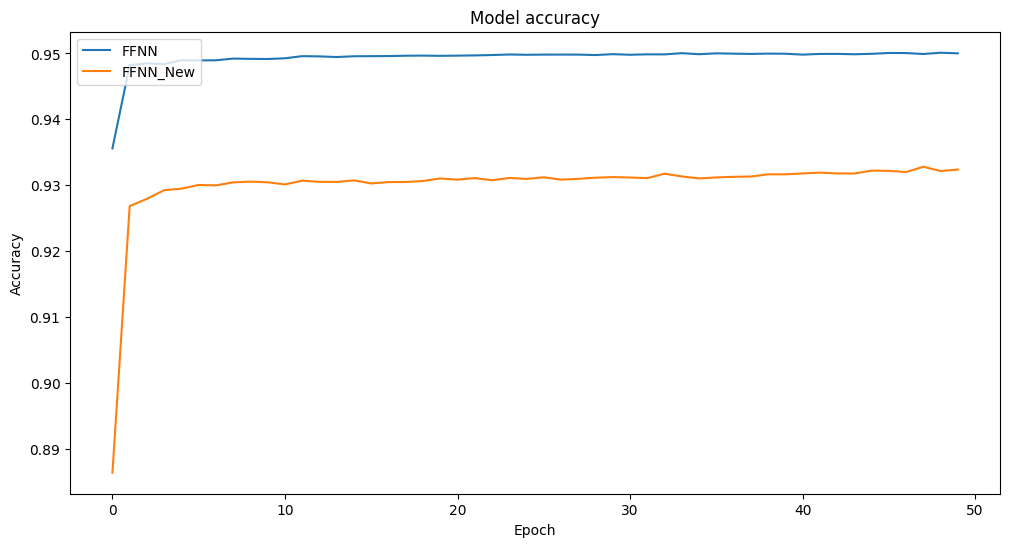

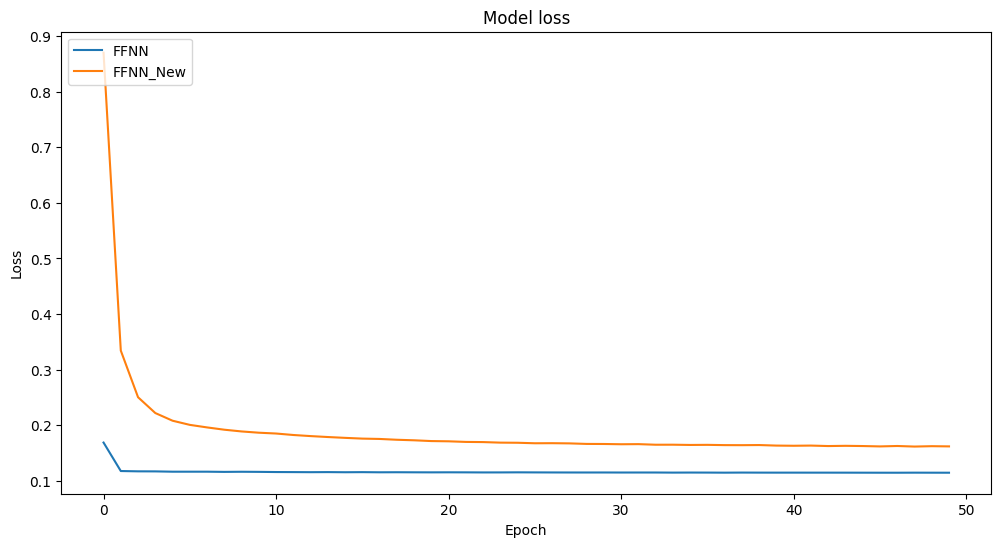

In [145]:
plot_history_two(history, history_ffnn_new, "FFNN", "FFNN_New")

In [144]:
X_train_rnn = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Define the model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(64, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model_rnn.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history_rnn_new = model_rnn.fit(X_train_rnn, y_train, epochs=50, batch_size=1000, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
557/557 [==============================] - 6s 7ms/step - loss: 0.6170 - accuracy: 0.8950 - val_loss: 0.2910 - val_accuracy: 0.9283
Epoch 2/50
557/557 [==============================] - 3s 6ms/step - loss: 0.3050 - accuracy: 0.9302 - val_loss: 0.2149 - val_accuracy: 0.9283
Epoch 3/50
557/557 [==============================] - 3s 6ms/step - loss: 0.2443 - accuracy: 0.9318 - val_loss: 0.1846 - val_accuracy: 0.9307
Epoch 4/50
557/557 [==============================] - 3s 6ms/step - loss: 0.2119 - accuracy: 0.9343 - val_loss: 0.1569 - val_accuracy: 0.9421
Epoch 5/50
557/557 [==============================] - 3s 6ms/step - loss: 0.1932 - accuracy: 0.9352 - val_loss: 0.1442 - val_accuracy: 0.9461
Epoch 6/50
557/557 [==============================] - 3s 6ms/step - loss: 0.1817 - accuracy: 0.9360 - val_loss: 0.1435 - val_accuracy: 0.9463
Epoch 7/50
557/557 [==============================] - 3s 6ms/step - loss: 0.1742 - accuracy: 0.9367 - val_loss: 0.1383 - val_accuracy: 0.9462
Epoch 

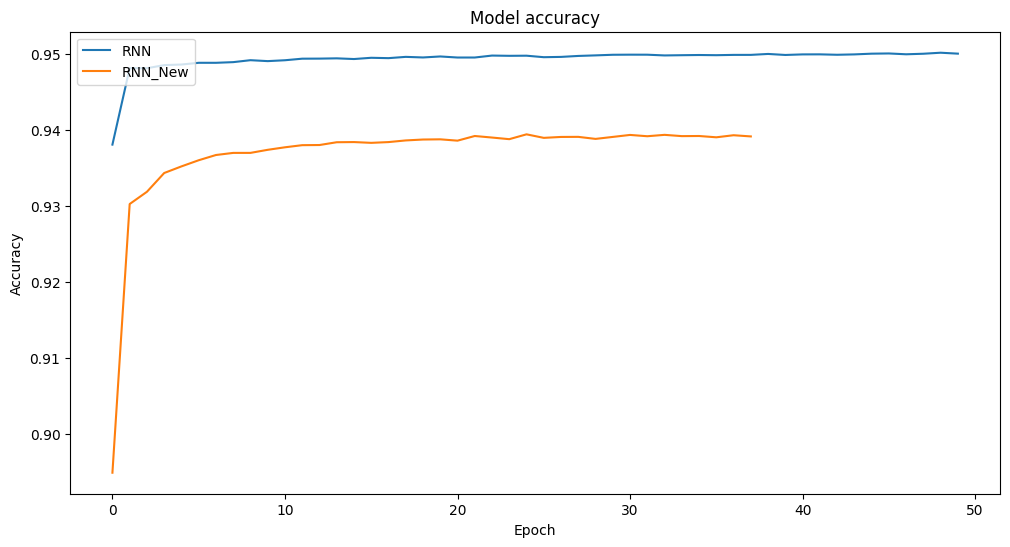

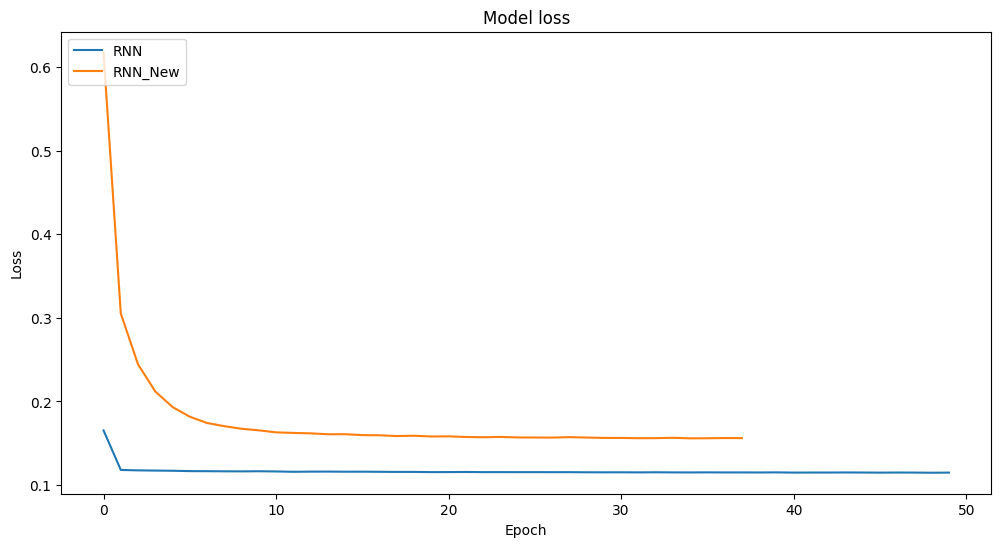

In [146]:
plot_history_two(history_rnn, history_rnn_new, "RNN", "RNN_New")

We can see that for the modified RNN model, there is an early stopping at around 38 epochs, which means there might be actual overfitting in the original model.

The Feed-Forward Neural Network (FFNN) and Recurrent Neural Network (RNN) models, after modifications to prevent overfitting, showed a decrease in accuracy of about 0.02. This could be due to the added regularization and dropout layers.

The loss for both models increased by approximately 0.05 in the modified versions, suggesting that they may not fit the training data as well as the original models. This could be attributed to the added complexity from the regularization and dropout layers.

In conclusion, while the modifications were intended to prevent overfitting, they seem to have resulted in slight underfitting, as indicated by the decreased accuracy and increased loss. These results suggest that further tuning of the model parameters or exploration of other overfitting prevention methods might be beneficial.

### Result analysis and Methods for Improvement in Accuracy

#### 5.1 Result Analysis

The models developed in this study, including basic models (e.g., Logistic Regression, Gradient Boosting), Feedforward Neural Network (FFNN), and Recurrent Neural Network (RNN), demonstrated good performance in predicting mortality based on medical history, with accuracy ranging from 0.90 to 0.95.

However, there were performance variations among the models. The Gradient Boosting and Logistic Regression models achieved the highest accuracy, while the Naive Bayes models had the lowest. The FFNN and RNN models showed comparable results with the basic models, but with a slight accuracy decrease after implementing overfitting prevention techniques.

In terms of feature importance, conditions like pneumonia, chronic renal disease, and COPD were strongly associated with mortality, while factors like COVID-19 status, obesity, and asthma had less impact. Age was also a significant factor, with mortality risk increasing with age.

#### 5.2 Methods for Improvement in Accuracy

While the models have shown good performance, there are several methods that could potentially improve their accuracy:

1. **Hyperparameter Tuning**: Performance can often be improved by tuning model hyperparameters using techniques such as grid search or random search.

2. **Feature Engineering**: Creating new features from existing data can sometimes enhance model performance. For instance, interaction terms between different diseases could be added to capture the combined effect of multiple conditions.

3. **Advanced Models**: More advanced models, such as XGBoost or LightGBM, could potentially improve accuracy due to their ability to handle complex interactions and non-linear relationships.

4. **Deep Learning**: More complex neural network architectures, such as Convolutional Neural Networks (CNNs) or Long Short-Term Memory networks (LSTMs), could be explored.

5. **Ensemble Methods**: Combining the predictions of multiple models can often lead to better performance than any single model.

6. **Data Augmentation**: If the dataset is imbalanced or small, data augmentation techniques can be used to increase the size and diversity of the training data.